<span style="font-size: 14pt">EREVAN, May-June 2017</span>

<span style="font-size: 16pt"> Seminar #1: Inroduction into Time Series Analysis

<span style="color:blue; font-size: 12pt">Alexey Romanenko </span>,
<span style="color:blue; font-size: 12pt; font-family: 'Verdana'">alexromsput@gmail.com</span>

<h3> Plan </h3>
  * **Remind: Regression**
  * **Autoregression Model**
  * **HW** 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn import model_selection
import scipy as sc

%matplotlib inline

<h1 align="center"> Remind: Regression </h1>

In [2]:
from IPython.display import IFrame
IFrame(src="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#examples-using-sklearn-linear-model-linearregression", width=800, height=400)

In [3]:
from IPython.display import IFrame
IFrame(src="http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge", width=800, height=400)

## Underfitting VS Overfitting

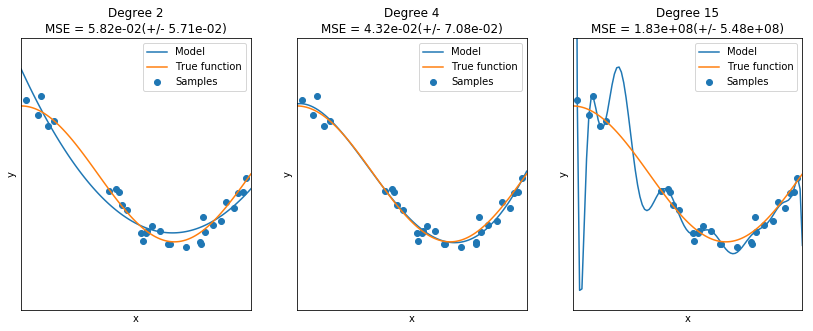

In [4]:
np.random.seed(0)

n_samples = 30
degrees = [2, 4, 15]

true_fun = lambda X: np.cos(1.5 * np.pi * X) # ещё один способ определить функцию: с помощью lambda-функции

# Data Generation
X = np.sort(np.random.rand(n_samples))
y = true_fun(X) + np.random.randn(n_samples) * 0.1

plt.figure(figsize=(14, 5))
for i in range(len(degrees)):
    ax = plt.subplot(1, len(degrees), i + 1)
    plt.setp(ax, xticks=(), yticks=())

    polynomial_features = PolynomialFeatures(degree=degrees[i],
                                             include_bias=False)
    linear_regression = LinearRegression()
    pipeline = Pipeline([("polynomial_features", polynomial_features),
                         ("linear_regression", linear_regression)])
    pipeline.fit(X[:, np.newaxis], y)

    # Evaluate the models using crossvalidation
    scores = model_selection.cross_val_score(pipeline,
        X[:, np.newaxis], y, scoring="neg_mean_squared_error", cv=10)

    X_test = np.linspace(0, 1, 100)
    plt.plot(X_test, pipeline.predict(X_test[:, np.newaxis]), label="Model")
    plt.plot(X_test, true_fun(X_test), label="True function")
    plt.scatter(X, y, label="Samples")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim((0, 1))
    plt.ylim((-2, 2))
    plt.legend(loc="best")
    plt.title("Degree {}\nMSE = {:.2e}(+/- {:.2e})".format(
        degrees[i], -scores.mean(), scores.std()))
plt.show()

<h1 align="center"> Autoregression</h1>

## Data: energy consumption

In [5]:
# Caution: different version of pandas needs differnt codes!!!
# ts = pd.read_csv('consumption_train.csv', sep='\t', decimal=',')
ts = pd.read_csv('consumption_train.csv', sep='\t', decimal='.', parse_dates=True, dayfirst=False, index_col='Dates') 
ts.head(10)

,EnergyCons,Dev,WeekDay
Dates,,,
2005-01-01 00:00:00,1290,-11,6
2005-01-01 01:00:00,1266,-12,6
2005-01-01 02:00:00,1273,-13,6
2005-01-01 03:00:00,1280,-14,6
2005-01-01 04:00:00,1293,-15,6
2005-01-01 05:00:00,1263,-16,6
2005-01-01 06:00:00,1279,-16,6
2005-01-01 07:00:00,1304,-16,6
2005-01-01 08:00:00,1330,-16,6


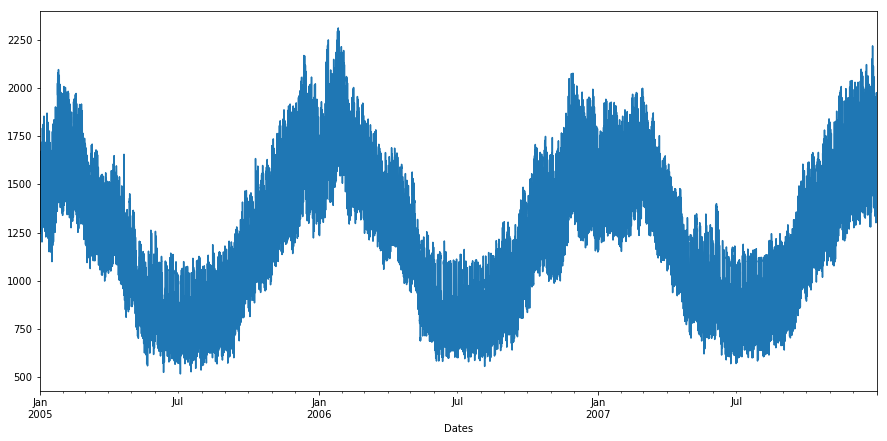

In [6]:
# Plot time series
ts['EnergyCons'].plot(figsize=(15,7))

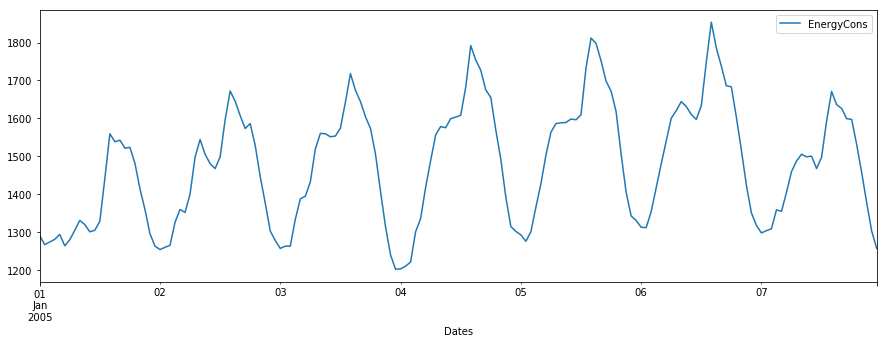

In [7]:
# the first week
ts.ix['2005-01-01 00:00:00':'2005-01-07 23:00:00', range(1)].plot(figsize=(15,5))

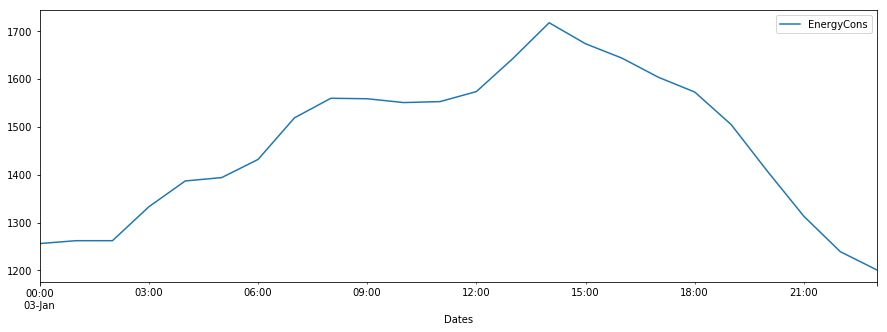

In [8]:
# the first day
ts.ix['2005-01-03 00:00:00':'2005-01-03 23:00:00', range(1)].plot(figsize=(15,5))

## STL-decomposition

In [9]:
import statsmodels.api as sm

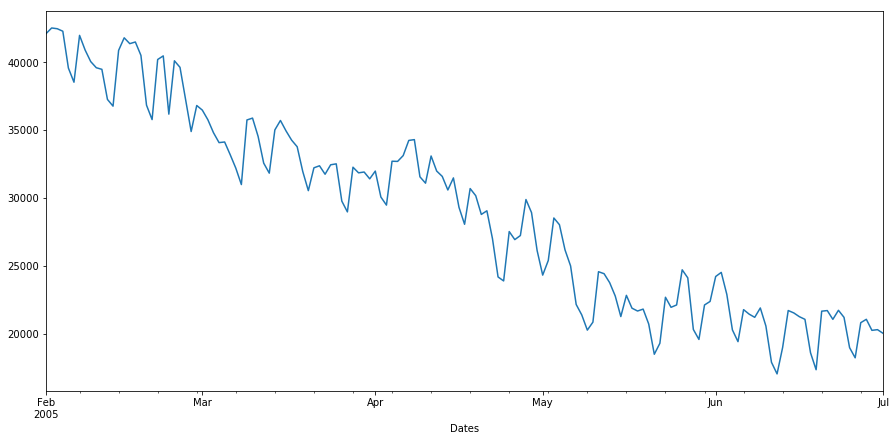

In [10]:
ts['EnergyCons'].ix['2005-02-01 00:00':'2005-07-01 23:00'].resample("D").sum().plot(figsize=(15,7))

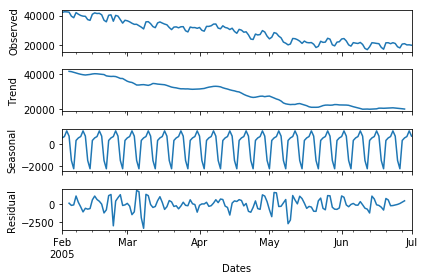

In [9]:
res = sm.tsa.seasonal_decompose(ts['EnergyCons'].ix['2005-02-01 00:00':'2005-07-01 23:00'].resample("D").sum())
resplot = res.plot()
# sm.tsa.seasonal_decompose(ts['EnergyCons'].ix['2005-02-01 00:00':'2005-07-01 23:00'].resample("D").sum(), freq="D")

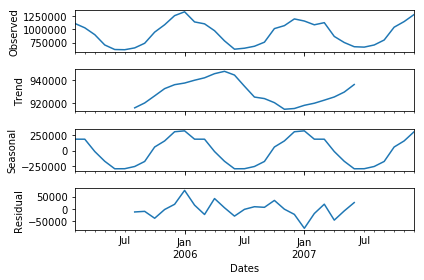

In [11]:
# fig = plt.figure(figsize=(15,10))
res = sm.tsa.seasonal_decompose(ts['EnergyCons'].ix['2005-02-01 00:00':'2008-01-01 23:00'].resample("M").sum())
resplot = res.plot()

## Autoregression: build matrix of autoregression

In [12]:
sc.linalg.hankel([1,2,3,4], [7,7,8,9])

array([[1, 2, 3, 4],
       [2, 3, 4, 7],
       [3, 4, 7, 8],
       [4, 7, 8, 9]])

In [13]:
def get_autoregrmatrix(x,h,K):
    L = len(x)
    X = sc.linalg.hankel(x[:L-h-K+1],
                        np.hstack([[x[-K]], x[-K:-1]])) # is needed to repeat x[-K] in second part
    y = x[K+h-1:]
    return X,y

In [14]:
x = np.arange(5)
get_autoregrmatrix(x,1,2)

(array([[0, 1],
        [1, 2],
        [2, 3]]), array([2, 3, 4]))

## Forecast for next hour (h=1) using 1 week history (K=168)

In [15]:
K=168
h = 1 # delay

x_train = ts['EnergyCons'].ix['2005-01-01 00:00:00':'2006-01-01 00:00:00']
x_test = ts['EnergyCons'].ix['2006-01-01 00:00:00':'2006-01-30 00:00:00']

X_train, y_train = get_autoregrmatrix(x_train,h,K)
X_test, y_test = get_autoregrmatrix(x_test,h,K)

In [16]:
print (X_train.shape)
print (y_train.shape)

(8593, 168)
(8593,)


In [17]:
# Matrix of Samples and Regressors
X_train

array([[1290, 1266, 1273, ..., 1377, 1302, 1256],
       [1266, 1273, 1280, ..., 1302, 1256, 1257],
       [1273, 1280, 1293, ..., 1256, 1257, 1267],
       ..., 
       [1332, 1293, 1225, ..., 1645, 1541, 1394],
       [1293, 1225, 1235, ..., 1541, 1394, 1349],
       [1225, 1235, 1222, ..., 1394, 1349, 1312]])

In [18]:
# Target Vector
y_train

Dates
2005-01-08 00:00:00    1257
2005-01-08 01:00:00    1267
2005-01-08 02:00:00    1274
2005-01-08 03:00:00    1339
2005-01-08 04:00:00    1376
2005-01-08 05:00:00    1400
2005-01-08 06:00:00    1439
2005-01-08 07:00:00    1504
2005-01-08 08:00:00    1557
2005-01-08 09:00:00    1518
2005-01-08 10:00:00    1500
2005-01-08 11:00:00    1501
2005-01-08 12:00:00    1546
2005-01-08 13:00:00    1645
2005-01-08 14:00:00    1718
2005-01-08 15:00:00    1701
2005-01-08 16:00:00    1655
2005-01-08 17:00:00    1635
2005-01-08 18:00:00    1616
2005-01-08 19:00:00    1530
2005-01-08 20:00:00    1435
2005-01-08 21:00:00    1349
2005-01-08 22:00:00    1266
2005-01-08 23:00:00    1247
2005-01-09 00:00:00    1227
2005-01-09 01:00:00    1252
2005-01-09 02:00:00    1250
2005-01-09 03:00:00    1298
2005-01-09 04:00:00    1355
2005-01-09 05:00:00    1384
                       ... 
2005-12-30 19:00:00    1682
2005-12-30 20:00:00    1586
2005-12-30 21:00:00    1484
2005-12-30 22:00:00    1401
2005-12-30 23:

Train score: 0.997, Test score: 0.991


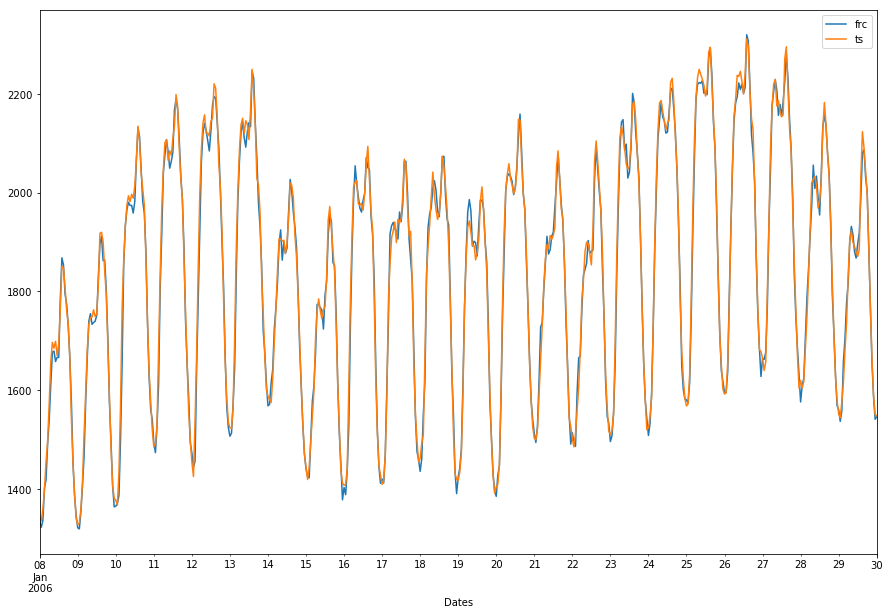

In [19]:
linear_regression = LinearRegression()
linear_regression.fit(X_train,y_train)
print('Train score: %.3f, Test score: %.3f'% (linear_regression.score(X_train, y_train), linear_regression.score(X_test, y_test)))
pd.DataFrame({'ts':y_test, 'frc': linear_regression.predict(X_test)}).plot(figsize=(15,10))

## Try another delay: h=168

Train score: 0.933, Test score: 0.839


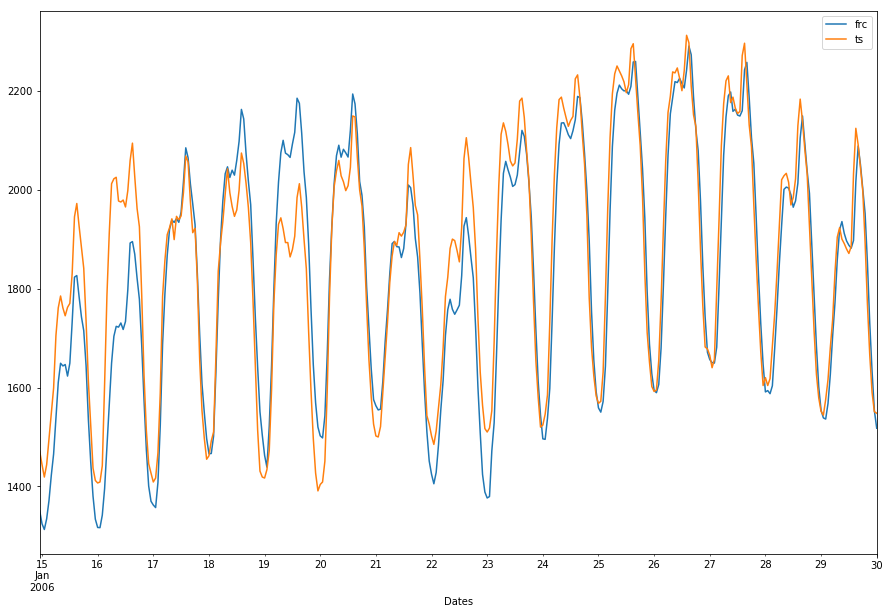

In [20]:
K=168
h = 168 # delay

x_train = ts['EnergyCons'].ix['2005-01-01 00:00:00':'2006-01-01 00:00:00']
x_test = ts['EnergyCons'].ix['2006-01-01 00:00:00':'2006-01-30 00:00:00']

X_train, y_train = get_autoregrmatrix(x_train,h,K)
X_test, y_test = get_autoregrmatrix(x_test,h,K)
linear_regression = LinearRegression()
linear_regression.fit(X_train,y_train)
print('Train score: %.3f, Test score: %.3f'% (linear_regression.score(X_train, y_train), linear_regression.score(X_test, y_test)))
pd.DataFrame({'ts':y_test, 'frc': linear_regression.predict(X_test)}).plot(figsize=(15,10))

<h1 align="center"> Home Work 0</h1>

## Answer to questions 
  ** 1. What is time series? **
     
Time series is a sequense of values of some variable, detected in a constant time interval.
       
  ** 2. What is delay and horizon of forecast?**
   
Time series task is to find some function that predicts the values of some variable with some delay (that means how far we want to predict). And the maximal value of delay set is called horizon.
         
  ** 3. What is Least Squared Method for Linear Regression?**
  
Let X (from $R^n$) is samples and Y (from $R$) is true values of our samples. Than our loss function written in LSM is: $L = \sum_{i=1}^n (x_{i}\alpha-y_{i})^2$
       
  ** 4. What is the solution of linear regression via LS method (in terms of matrix $X, \alpha, Y$)? **
  
The solution os linear regression is: $\alpha^* = (X^TX)^{-1}X^TY $
          
  ** 5. Write down main problems of LS method. **

1. LSM doesn't work when $det(X^TX) = 0$, i.e. X is singular matrix.
2. LSM doesn't take into account seasonality in TS.

  ** 6. What hankel transformation of a matrix? **
  
Let $v_1$ and $v_2$ are vectors. By henkel transformation we get matrix, where:
1. first column is $v_1$, last row is $v_2$.
2. each element is equal to an element in it's previos column of the next row.


## Practical Task
Draw dependence of the cross_validation score (linear_regression.score) on the horizon of the forecast for LR model in the case of energy consumption forecasting. You should write code to show dependence for $h=1,2,\dots, 720$. You can choose amount of regressors fo LR in experiment as much as you want.   

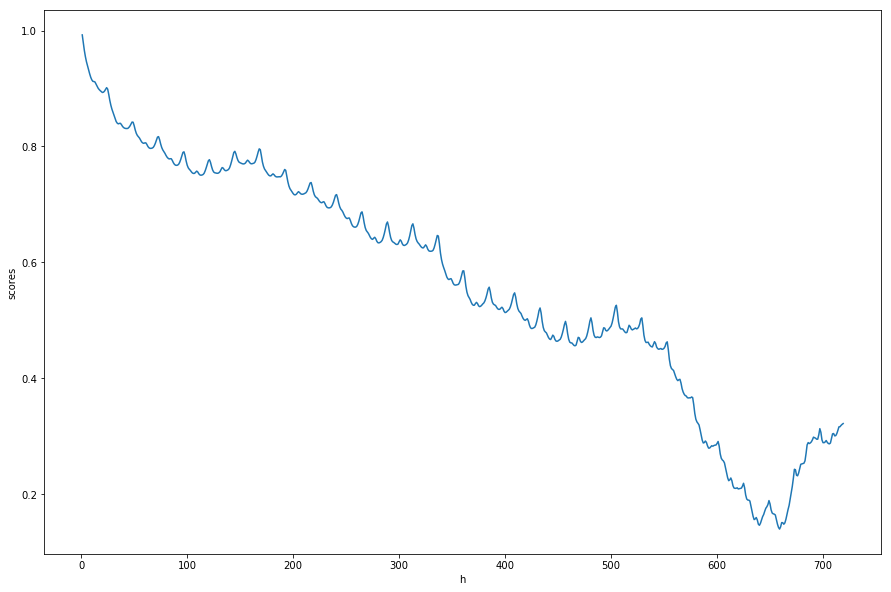

In [21]:
# Solution wirte there
linear_regression = LinearRegression()
K=168
H=range(1,720)
plt.figure(figsize=(15,10))
scores = []
for h in H:
    
    x_train = ts['EnergyCons'].ix['2005-01-01 00:00:00':'2006-01-01 00:00:00']
    x_test = ts['EnergyCons'].ix['2006-01-01 00:00:00':'2006-03-30 00:00:00']
    
    X_train, y_train = get_autoregrmatrix(x_train,h,K)
    X_test, y_test = get_autoregrmatrix(x_test,h,K)
    
    
    linear_regression.fit(X_train,y_train)
    scores.append(linear_regression.score(X_test, y_test))

plt.xlabel("h")
plt.ylabel("scores")
plt.plot(H, scores)